In [1]:
# A command the clears the output of a code cell
from IPython.display import clear_output

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [5]:
# You can replace this GitHub link with your forked repository if you want
!git clone https://github.com/eric-zhizu/EmotionalConversionStarGAN.git
clear_output()

In [6]:
%cd EmotionalConversionStarGAN
!git checkout eric-implementation

/content/EmotionalConversionStarGAN
Branch 'eric-implementation' set up to track remote branch 'eric-implementation' from 'origin'.
Switched to a new branch 'eric-implementation'


In [4]:
!unzip /content/gdrive/MyDrive/esd_ser_processed_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: processed_data/f0/0001_001080.npy  
  inflating: processed_data/f0/0010_000652.npy  
  inflating: processed_data/f0/0016_000281.npy  
  inflating: processed_data/f0/0009_001109.npy  
  inflating: processed_data/f0/0010_000794.npy  
  inflating: processed_data/f0/0002_000201.npy  
  inflating: processed_data/f0/0015_000507.npy  
  inflating: processed_data/f0/0015_000558.npy  
  inflating: processed_data/f0/0004_001333.npy  
  inflating: processed_data/f0/0005_000061.npy  
  inflating: processed_data/f0/0017_000715.npy  
  inflating: processed_data/f0/0018_000358.npy  
  inflating: processed_data/f0/0011_000871.npy  
  inflating: processed_data/f0/0009_000093.npy  
  inflating: processed_data/f0/0010_001104.npy  
  inflating: processed_data/f0/0011_000604.npy  
  inflating: processed_data/f0/0019_000829.npy  
  inflating: processed_data/f0/0004_001006.npy  
  inflating: processed_data/f0/0015_001224.npy  
  inflating: proce

In [ ]:
!mv processed_data /content/EmotionalConversionStarGAN

mv: cannot stat 'processed_data': No such file or directory


In [7]:
!pip install librosa pyworld tensorflow==1.15 transformers
clear_output()

In [ ]:
%cd /content/
!git clone https://github.com/speechbrain/speechbrain.git
%cd speechbrain
%pip install -r requirements.txt
%pip install --editable .
# MUST RESTART RUNTIME FOR SPEECHBRAIN TO APPEAR

/content
Cloning into 'speechbrain'...
remote: Enumerating objects: 45369, done.
remote: Counting objects: 100% (2132/2132), done.
remote: Compressing objects: 100% (981/981), done.
remote: Total 45369 (delta 1259), reused 1801 (delta 1087), pack-reused 43237
Receiving objects: 100% (45369/45369), 59.96 MiB | 26.96 MiB/s, done.
Resolving deltas: 100% (28982/28982), done.
/content/speechbrain
Ignoring SoundFile: markers 'sys_platform == "win32"' don't match your environment
     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 69 kB 8.2 MB/s 
     |████████████████████████████████| 51 kB 7.1 MB/s 
     |████████████████████████████████| 246 kB 43.3 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 191 kB 57.2 MB/s 
     |████████████████████████████████| 1.2 MB 52.7 MB/s 
     |████████████████████████████████| 843 kB 51.6 MB/s 
     |████████████████████████████████| 59 kB 7.5 MB/s 
     |████

# Set up classifier

In [ ]:
%cd /content/EmotionalConversionStarGAN
import os
import numpy as np
import torch
import torch.utils.data as data_utils
from tqdm import tqdm
import yaml

import stargan.my_dataset as my_dataset
from utils.data_preprocessing_utils import read_annotations

from speechbrain.pretrained.interfaces import foreign_class

/content/EmotionalConversionStarGAN


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

classifier = foreign_class(source="speechbrain/emotion-recognition-wav2vec2-IEMOCAP",
                            pymodule_file="custom_interface.py",
                            classname="CustomEncoderWav2vec2Classifier",
                            run_opts={"device":device})

Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/159 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/configuration_utils.py:341: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


Downloading:   0%|          | 0.00/378M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/83.0 [00:00<?, ?B/s]

In [ ]:
classifier.load_state_dict(torch.load('/content/gdrive/MyDrive/final_project/checkpoints/finetune_ser_epoch_15.ckpt'))
classifier = classifier.to(device)

In [ ]:
file2labels = read_annotations('processed_data/annotations')

In [ ]:
import pickle
with open('file_emo_mappings.pkl', 'rb') as f:
    file_emo_mappings = pickle.load(f)

In [ ]:
# Loop through audio files
from collections import defaultdict
from scipy.io import wavfile

embeddings_total = {}
embeddings_count = defaultdict(int)
# embeddings_dict = {}

def get_embedding(wav_file_path):
    wav_form = wavfile.read(wav_file_path)[1]

    # Feed a wav form (batch size 1) into the classifier
    wav_form = torch.Tensor(wav_form).unsqueeze(0).to(device)
    wav_length = torch.Tensor([1.0]).to(device) # 1 for max length

    embedding = classifier.encode_batch(wav_form, wav_length)
    return embedding

world_dir = 'processed_data/world'
for world_file in tqdm(os.listdir(world_dir)):
    file_id = world_file.split('.')[0]
    if file_id in embeddings_dict and embeddings_dict[file_id]:
        continue
    embeddings_dict[file_id] = {}

    # Read wav file
    wav_file_path = os.path.join('processed_data/audio', file_id + '.wav')
    if not os.path.exists(wav_file_path):
        continue

    # Get emotion label
    if file_id in file_emo_mappings:
        emo_label = file_emo_mappings[file_id]['Label']
    else: # Probably because it's a Mandarin speaker, not English
        continue

    # Calculate embedding for source emotion
    try:
        embedding = get_embedding(wav_file_path)
    except:
        continue

    # Keep running average of embeddings
    if emo_label not in embeddings_total:
        embeddings_total[emo_label] = embedding
    else:
        embeddings_total[emo_label] += embedding
    embeddings_count[emo_label] += 1

    # Add related emotion embeddings to embeddings_dict
    embeddings_dict[file_id][emo_label] = embedding
    for other_emo_label, other_file_id in file_emo_mappings[file_id].items():
        if other_emo_label == 'Label':
            continue
        other_file_path = os.path.join('processed_data/audio', other_file_id + '.wav')
        try:
            other_embedding = get_embedding(other_file_path)
        except:
            continue
        embeddings_dict[file_id][other_emo_label] = other_embedding

  1%|          | 158/27988 [00:07<22:24, 20.70it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: WavFileWarning: Chunk (non-data) not understood, skipping it.
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 27988/27988 [21:32<00:00, 21.65it/s]


In [ ]:
avg_neutral_embedding = embeddings_total['Neutral'].detach().cpu() / embeddings_count['Neutral']
avg_angry_embedding = embeddings_total['Angry'].detach().cpu() / embeddings_count['Angry']
avg_happy_embedding = embeddings_total['Happy'].detach().cpu() / embeddings_count['Happy']
avg_sad_embedding = embeddings_total['Sad'].detach().cpu() / embeddings_count['Sad']

In [ ]:
avg_neutral_embedding.shape

torch.Size([1, 768])

In [ ]:
!mkdir -p pretrained_ser_embed
torch.save(avg_neutral_embedding, 'pretrained_ser_embed/avg_neutral_embedding.pt')
torch.save(avg_angry_embedding, 'pretrained_ser_embed/avg_angry_embedding.pt')
torch.save(avg_sad_embedding, 'pretrained_ser_embed/avg_sad_embedding.pt')
torch.save(avg_happy_embedding, 'pretrained_ser_embed/avg_happy_embedding.pt')

In [ ]:
!mkdir -p finetuned_ser_embed
torch.save(avg_neutral_embedding, 'finetuned_ser_embed/avg_neutral_embedding.pt')
torch.save(avg_angry_embedding, 'finetuned_ser_embed/avg_angry_embedding.pt')
torch.save(avg_sad_embedding, 'finetuned_ser_embed/avg_sad_embedding.pt')
torch.save(avg_happy_embedding, 'finetuned_ser_embed/avg_happy_embedding.pt')

In [ ]:
!cp -r pretrained_ser_embed /content/gdrive/MyDrive/final_project/data/

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import os
!mkdir -p processed_data/emo_embeddings
for file_id, emo_dict in embeddings_dict.items():
    torch.save(emo_dict, os.path.join('processed_data/emo_embeddings', file_id + '.pt'))

In [ ]:
!zip -r esd_ser_processed_data.zip processed_data
!mv esd_ser_processed_data.zip /content/gdrive/MyDrive/final_project/data/
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Streaming output truncated to the last 5000 lines.
  adding: processed_data/f0/0010_000652.npy (deflated 30%)
  adding: processed_data/f0/0016_000281.npy (deflated 35%)
  adding: processed_data/f0/0009_001109.npy (deflated 23%)
  adding: processed_data/f0/0010_000794.npy (deflated 35%)
  adding: processed_data/f0/0002_000201.npy (deflated 36%)
  adding: processed_data/f0/0015_000507.npy (deflated 36%)
  adding: processed_data/f0/0015_000558.npy (deflated 35%)
  adding: processed_data/f0/0004_001333.npy (deflated 33%)
  adding: processed_data/f0/0005_000061.npy (deflated 26%)
  adding: processed_data/f0/0017_000715.npy (deflated 27%)
  adding: processed_data/f0/0018_000358.npy (deflated 44%)
  adding: processed_data/f0/0011_000871.npy (deflated 26%)
  adding: processed_data/f0/0009_000093.npy (deflated 27%)
  adding: processed_data/f0/0010_001104.npy (deflated 29%)
  adding: processed_data/f0/0011_000604.npy (deflated 53%)
  adding: processed_data/f0/0019_000829.npy (deflated 21%)
  add

In [ ]:
example_embed = torch.load('processed_data/emo_embeddings/0005_000506.pt')
print(torch.cdist(example_embed['Angry'], embeddings_dict['0005_000506']['Angry']))
print(torch.cdist(example_embed['Angry'], example_embed['Neutral']))

tensor([[0.]], device='cuda:0')
tensor([[33.8885]], device='cuda:0')


In [ ]:
print(torch.cdist(avg_neutral_embedding, avg_angry_embedding))
print(torch.cdist(avg_neutral_embedding, avg_happy_embedding))
print(torch.cdist(avg_neutral_embedding, avg_sad_embedding))

print(torch.cdist(avg_happy_embedding, avg_angry_embedding))
print(torch.cdist(avg_happy_embedding, avg_sad_embedding))

print(torch.cdist(avg_angry_embedding, avg_sad_embedding))

tensor([[31.5014]])
tensor([[30.3844]])
tensor([[30.6665]])
tensor([[27.8624]])
tensor([[27.3669]])
tensor([[29.8348]])


#Visualize Emotion Embeddings

In [ ]:
import os
import torch

lab2ind = {'Neutral': 0, 'Angry': 1, 'Happy': 2, 'Sad': 3}

data = []
labels = []
embed_dir = '/content/processed_data/emo_embeddings'
N = 1000
for i, embed_file in enumerate(os.listdir(embed_dir)):
    if i == N:
        break

    embed_path = os.path.join(embed_dir, embed_file)
    emo_embedding_dict = torch.load(embed_path)

    for emo_label, embedding in emo_embedding_dict.items():
        if emo_label not in lab2ind:
            continue

        emo_ind = lab2ind[emo_label]
        labels.append(emo_ind)
        data.append(embedding)

data = torch.vstack(data).detach().cpu()
labels = torch.tensor(labels).unsqueeze(1)
data = torch.cat((data, labels), dim=1)

In [ ]:
import pandas as pd
n_features = data.shape[1] - 1
feature_cols = ['feature' + str(i) for i in range(n_features)]
df = pd.DataFrame(data, columns=feature_cols + ['y'])
print("Created data frame of length", len(df))

Created data frame of length 3874


In [ ]:
ind2lab = {
    0: 'neu',
    1: 'ang',
    2: 'hap',
    3: 'sad'
}
df['label'] = df['y'].apply(lambda index: ind2lab[int(index)])

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3874 samples in 0.003s...
[t-SNE] Computed neighbors for 3874 samples in 0.708s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3874
[t-SNE] Computed conditional probabilities for sample 2000 / 3874
[t-SNE] Computed conditional probabilities for sample 3000 / 3874
[t-SNE] Computed conditional probabilities for sample 3874 / 3874
[t-SNE] Mean sigma: 0.845735
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.657486
[t-SNE] KL divergence after 3000 iterations: 0.926348
t-SNE done! Time elapsed: 56.70421004295349 seconds


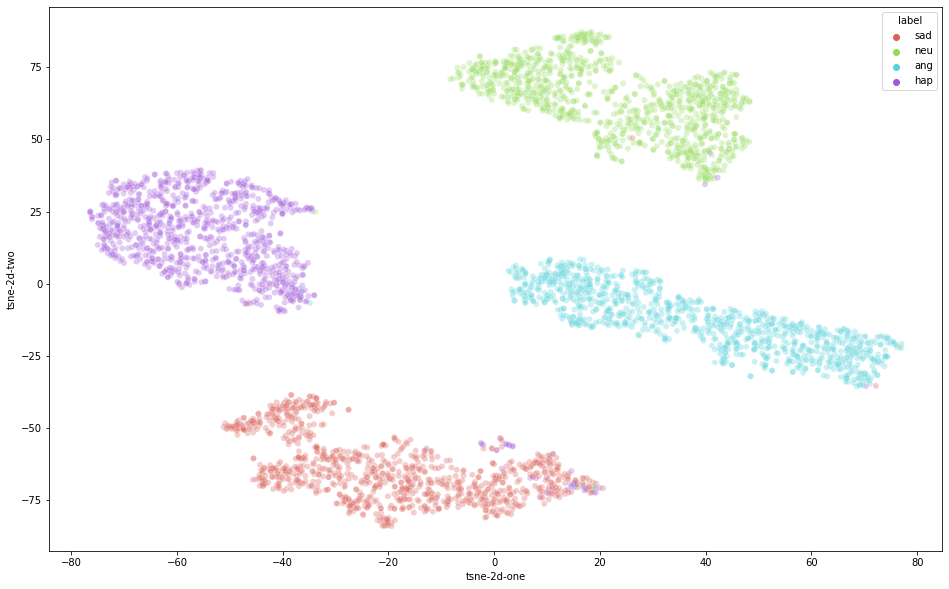

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
import time

%matplotlib inline
###
#   Perform dimensionality reduction using t-SNE
###

"""
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

# Plot only a random 5000 samples to reduce computation time
N = 5000
df_subset = df.loc[rndperm[:N], :].copy()
data_subset = df_subset[feature_cols].values
"""

df_subset = df
data_subset = df_subset[feature_cols].values

# Perform t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(data_subset)
print(f't-SNE done! Time elapsed: {time.time() - time_start} seconds')

# Add t-SNE results to the data frame to plot
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='label',
    palette=sns.color_palette('hls', 4),
    data=df_subset,
    legend='full',
    alpha=0.3
)